# Greeks

In [1]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd

# URL of the page
url = 'https://www.m-x.ca/en/trading/data/quotes?symbol=BTCC*'

# Send a GET request to the URL
response = requests.get(url)

# Parse the HTML content of the page
soup = BeautifulSoup(response.text, 'html.parser')

# Find the table
table = soup.find('tbody', {'class': 'text-right nowrap'})

# Initialize an empty list to store the data
options_data = []

# Check if the table is found
if table:
    # Iterate over each row in the table
    for row in table.find_all('tr'):
        try:
            # Extract data for each attribute, with error handling
            strike_price = row.find('td', class_='strike_price').text.strip()

            # Call option data extraction
            call_data_row = json.loads(row['data-row'].replace('&quot;', '"'))
            call_expiry_date = call_data_row['call']['expiry_date'] if 'call' in call_data_row else 'N/A'
            call_bid_price = row.find('td', class_='call bid_price').text.strip()
            call_ask_price = row.find('td', class_='call ask_price').text.strip()
            call_last_price = row.find('td', class_='call last_price').text.strip()

            # Put option data extraction
            put_data_row = json.loads(row['data-row'].replace('&quot;', '"'))
            put_expiry_date = put_data_row['put']['expiry_date'] if 'put' in put_data_row else 'N/A'
            put_bid_price = row.find('td', class_='put bid_price').text.strip()
            put_ask_price = row.find('td', class_='put ask_price').text.strip()
            
            # Append the data to the list
            options_data.append({
                'Type': 'Call',
                'Date': call_expiry_date,
                'Strike': strike_price,
                'Bid': call_bid_price,
                'Ask': call_ask_price,
                'Last': call_last_price
            })
            options_data.append({
                'Type': 'Put',
                'Date': put_expiry_date,
                'Strike': strike_price,
                'Bid': put_bid_price,
                'Ask': put_ask_price
            })
        except (AttributeError, KeyError, json.JSONDecodeError) as e:
            print(f"Error extracting data from row: {e}")
else:
    print("Table not found.")

# Convert the list to a DataFrame
df = pd.DataFrame(options_data)

# Convert 'Expiry Date' to datetime and sort by it
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by=['Type', 'Date', 'Strike'], inplace=True)

# Convert 'Strike', 'Bid', 'Ask', and 'Last' columns to numeric (float)
df['Strike'] = pd.to_numeric(df['Strike'], errors='coerce')
df['Bid'] = pd.to_numeric(df['Bid'], errors='coerce')
df['Ask'] = pd.to_numeric(df['Ask'], errors='coerce')
df['Last'] = pd.to_numeric(df['Last'], errors='coerce')

df


,Type,Date,Strike,Bid,Ask,Last
136,Call,2024-03-15,10.0,0.0,0.0,3.60
138,Call,2024-03-15,10.5,0.0,0.0,3.10
140,Call,2024-03-15,11.0,0.0,0.0,2.59
142,Call,2024-03-15,11.5,1.1,0.0,2.10
144,Call,2024-03-15,12.0,0.0,0.0,1.60
...,...,...,...,...,...,...
621,Put,2026-01-16,5.0,0.0,0.0,NaN
623,Put,2026-01-16,6.0,0.0,0.0,NaN
625,Put,2026-01-16,7.0,0.0,0.0,NaN
627,Put,2026-01-16,8.0,0.0,0.0,NaN


In [2]:
# All options expire on January 16th 2026

import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pytz

# Retrieve historical data
ticker = "BTCC-B.TO"
start_time = (datetime.now(pytz.timezone('US/Pacific')) - timedelta(days=365*4)).strftime('%Y-%m-%d')
end_time = (datetime.now(pytz.timezone('US/Pacific'))).strftime('%Y-%m-%d')

data = yf.download(ticker, start=start_time, end=end_time, interval="1d")[['Close']]
data['Daily_Return'] = data['Close'].pct_change()

daily_volatility = data['Daily_Return'].std()
annualized_volatility = daily_volatility * np.sqrt(252)

risk_free_rate = 0.045

current_stock_price = data['Close'].iloc[-1]  
print(current_stock_price)

[*********************100%%**********************]  1 of 1 completed

14.1899995803833



C:\Users\falty\AppData\Local\Temp\ipykernel_10628\1888896037.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Daily_Return'] = data['Close'].pct_change()


In [3]:
df = df.dropna(subset=['Last'])
df['Type'].unique()

array(['Call'], dtype=object)

In [7]:
import mibian

def calculate_greeks(row, current_stock_price, risk_free_rate, annualized_volatility):
    # Check for NaN values in the required fields
    if pd.isna(row['Strike']) or pd.isna(row['Last']):
        return pd.Series({'Delta': np.nan, 'Gamma': np.nan, 'Theta': np.nan, 'Vega': np.nan})

    # Time to expiration in days
    days_to_expiration = (row['Date'] - pd.Timestamp.now()).days

    # Check if days_to_expiration is zero or negative, or if volatility is zero
    if days_to_expiration <= 0 or annualized_volatility <= 0:
        return pd.Series({'Delta': np.nan, 'Gamma': np.nan, 'Theta': np.nan, 'Vega': np.nan})

    if row['Type'] == 'Call':
        option = mibian.BS([current_stock_price, row['Strike'], risk_free_rate * 100, days_to_expiration], volatility=annualized_volatility * 100)
    else:  # Put
        option = mibian.BS([current_stock_price, row['Strike'], risk_free_rate * 100, days_to_expiration], putPrice=row['Last'], volatility=annualized_volatility * 100)
    
    return pd.Series({
        'Delta': option.callDelta if row['Type'] == 'Call' else option.putDelta,
        'Gamma': option.gamma,
        'Theta': option.callTheta if row['Type'] == 'Call' else option.putTheta,
        'Vega': option.vega
    })

# Apply the function to each row in the DataFrame
greeks = df.apply(lambda row: calculate_greeks(row, current_stock_price, risk_free_rate, annualized_volatility), axis=1)

# Combine the Greeks with the original DataFrame
df_with_greeks = pd.concat([df, greeks], axis=1)

df_with_greeks = df_with_greeks.dropna(subset=['Delta'])
df_with_greeks

,Type,Date,Strike,Bid,Ask,Last,Delta,Gamma,Theta,Vega
10,Call,2024-03-22,10.0,0.00,0.00,3.67,0.999991,0.000034,-0.001235,7.921707e-07
12,Call,2024-03-22,10.5,0.00,0.00,3.18,0.999892,0.000364,-0.001329,8.388295e-06
14,Call,2024-03-22,11.0,0.00,0.00,2.72,0.999142,0.002497,-0.001598,5.749871e-05
16,Call,2024-03-22,11.5,0.00,0.00,2.26,0.995299,0.011681,-0.002554,2.689725e-04
18,Call,2024-03-22,12.0,0.00,0.00,1.90,0.981314,0.039001,-0.005270,8.980842e-04
...,...,...,...,...,...,...,...,...,...,...
620,Call,2026-01-16,5.0,0.00,12.00,9.55,0.963764,0.006924,-0.001155,1.530681e-02
622,Call,2026-01-16,6.0,1.08,9.00,8.50,0.941886,0.010119,-0.001521,2.236832e-02
624,Call,2026-01-16,7.0,0.00,19.95,7.90,0.916251,0.013403,-0.001883,2.962934e-02
626,Call,2026-01-16,8.0,0.00,12.00,7.50,0.887865,0.016605,-0.002226,3.670609e-02


In [8]:
df_with_greeks['Theta'].min()

-0.033581881365068254

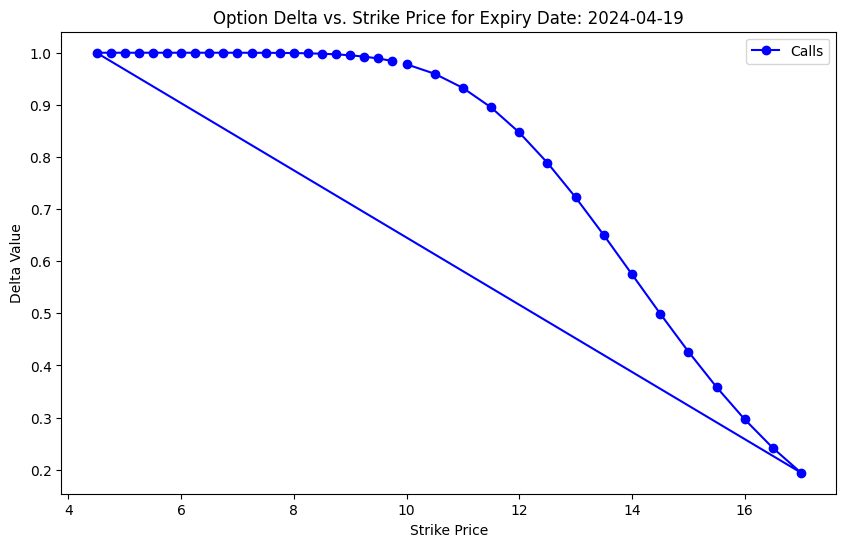

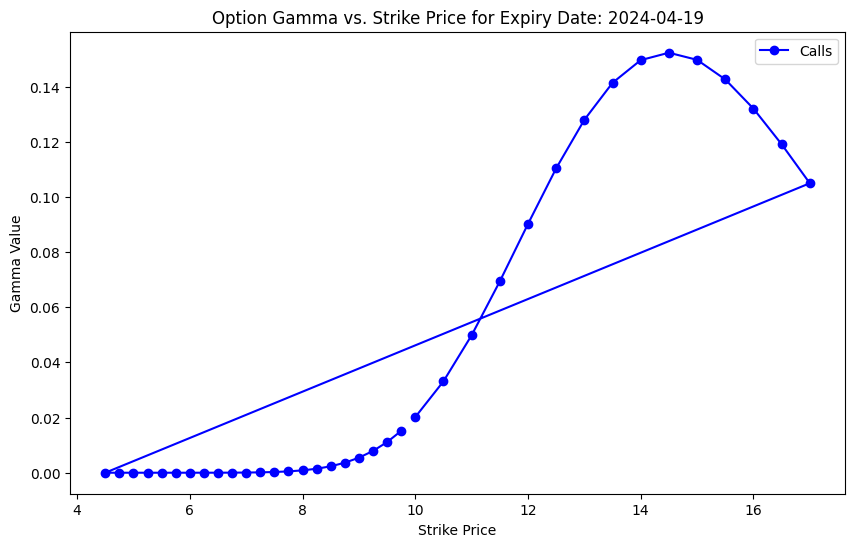

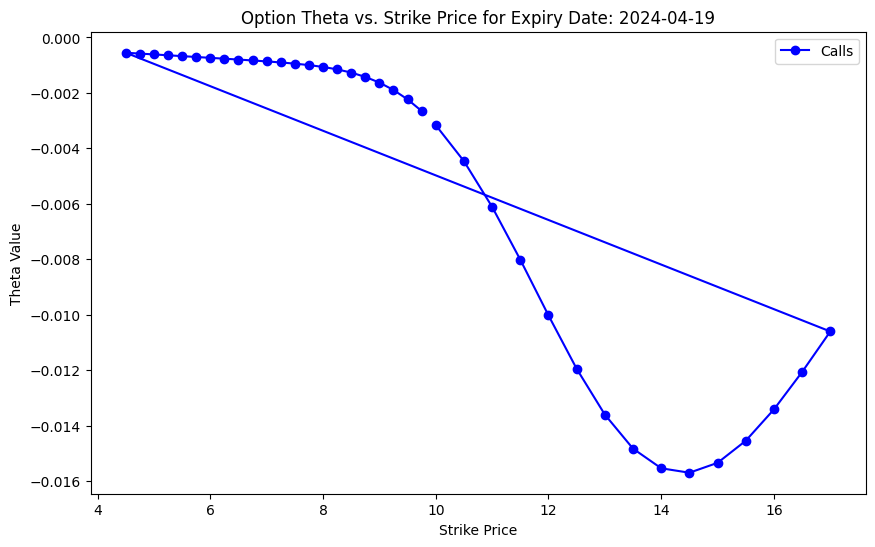

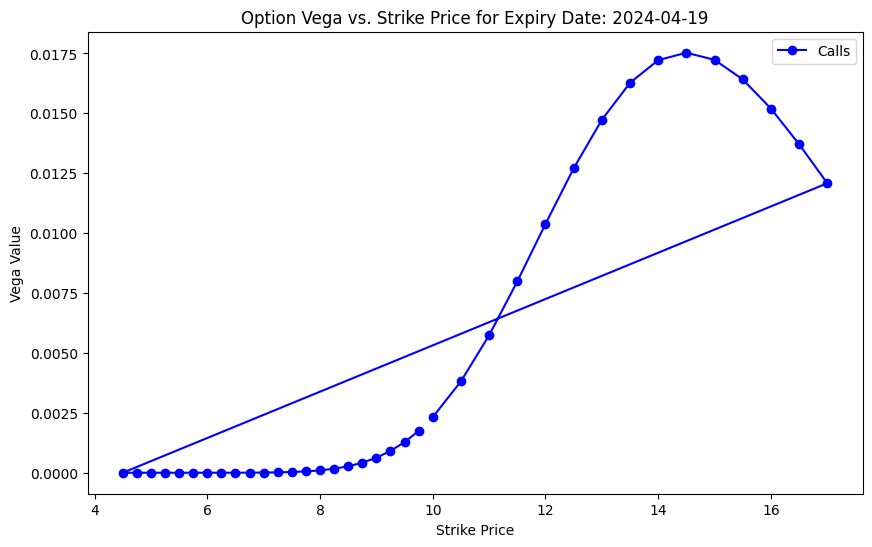

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Define your target date here (YYYY-MM-DD format)
target_date = '2024-04-19'
target_date = pd.to_datetime(target_date)

# Filter the DataFrame for the target date
filtered_df = df_with_greeks[df_with_greeks['Date'] == target_date]

# Define a dictionary for Greek names and their corresponding colors
greek_colors = {'Delta': 'blue', 'Gamma': 'red', 'Theta': 'green', 'Vega': 'purple'}

# Plot each Greek
for greek in ['Delta', 'Gamma', 'Theta', 'Vega']:
    plt.figure(figsize=(10, 6))

    # Plotting for calls and puts separately
    if not filtered_df[filtered_df['Type'] == 'Call'].empty:
        calls = filtered_df[filtered_df['Type'] == 'Call']
        plt.plot(calls['Strike'], calls[greek], marker='o', linestyle='-', color='blue', label='Calls')
    if not filtered_df[filtered_df['Type'] == 'Put'].empty:
        puts = filtered_df[filtered_df['Type'] == 'Put']
        plt.plot(puts['Strike'], puts[greek], marker='o', linestyle='-', color='red', label='Puts')

    # Setting linear scale for y-axis
    plt.yscale('linear')

    # Setting labels, title and legend
    plt.xlabel('Strike Price')
    plt.ylabel(f'{greek} Value')
    plt.title(f'Option {greek} vs. Strike Price for Expiry Date: {target_date.date()}')
    plt.legend()

    # Show the plot
    plt.show()
